In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 读取图片

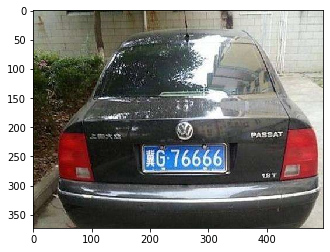

In [2]:
src_img = cv2.imread("car.jpg")
# cv2 图片格式是BGR，需要转为RGB通道格式
src_img = cv2.cvtColor(src_img,cv2.COLOR_BGR2RGB)
plt.imshow(src_img)

## 预处理

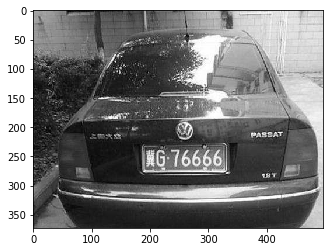

In [3]:
# 转为灰度图
gray_img = cv2.cvtColor(src_img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img,cmap="gray")

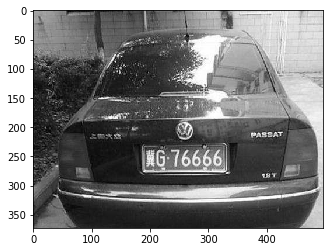

In [4]:
# 灰度拉伸
def stretch(img):
    max = float(img.max())
    min = float(img.min())
 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i, j] = (255/(max-min))*img[i,j]-(255*min)/(max-min)
    return img
stretch_img = stretch(gray_img)
plt.imshow(stretch_img,cmap="gray")

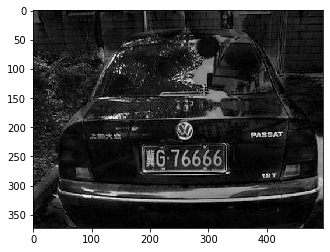

In [5]:
# 开运算
r = 16
h = w = r * 2 + 1
kernel = np.zeros((h, w), dtype=np.uint8)
cv2.circle(kernel, (r, r), r, 1, -1)     
openingimg = cv2.morphologyEx(stretch_img, cv2.MORPH_OPEN, kernel)
strtimg = cv2.absdiff(stretch_img,openingimg)
plt.imshow(strtimg,cmap="gray")

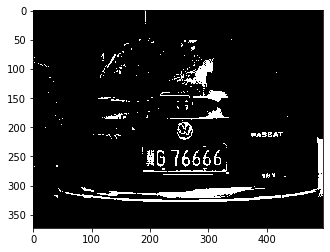

In [6]:
# 二值化

def binary(img):
    max = float(img.max())
    min = float(img.min())
     
    x = max - ((max-min) / 2)
    ret, threshedimg = cv2.threshold(img, x, 255, cv2.THRESH_BINARY)
     
    return threshedimg
binary_img = binary(strtimg)
plt.imshow(binary_img,cmap="gray")

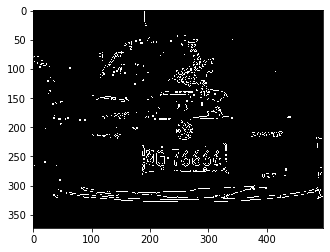

In [7]:
# 边缘检测
canny_img = cv2.Canny(binary_img, binary_img.shape[0], binary_img.shape[1])
plt.imshow(canny_img,cmap="gray")

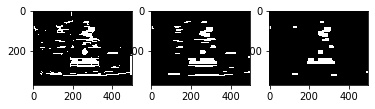

In [8]:
# 闭运算
kernel = np.ones((5,19), np.uint8)
closing_img = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, kernel)
ax1 = plt.subplot(1,3,1)
plt.imshow(closing_img,cmap="gray")
# 进行开运算
opening_img = cv2.morphologyEx(closing_img, cv2.MORPH_OPEN, kernel)
ax2 = plt.subplot(1,3,2)
plt.imshow(opening_img,cmap="gray")
# 再次进行开运算
kernel = np.ones((11,5), np.uint8)
ax3 = plt.subplot(1,3,3)
opening_img = cv2.morphologyEx(opening_img, cv2.MORPH_OPEN, kernel)
plt.imshow(opening_img,cmap="gray")

## 定位

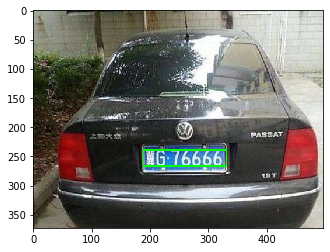

In [9]:
def find_retangle(contour):
    y, x = [], []

    for p in contour:
        y.append(p[0][0])
        x.append(p[0][1])

    return [min(y), min(x), max(y), max(x)]


def locate_license(img, orgimg):
    contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
    # 找出最大的三个区域
    blocks = []
    for c in contours:
        # 找出轮廓的左上点和右下点，由此计算它的面积和长宽比
        r = find_retangle(c)
        a = (r[2]-r[0]) * (r[3]-r[1])
        s = (r[2]-r[0]) / (r[3]-r[1])
        blocks.append([r, a, s])
    # 选出面积最大的3个区域
    blocks = sorted(blocks, key=lambda b: b[2])[-3:]

    # 使用颜色识别判断找出最像车牌的区域
    maxweight, maxindex = 0, -1
    for i in range(len(blocks)):
        b = orgimg[blocks[i][0][1]:blocks[i][0][3], blocks[i][0][0]:blocks[i][0][2]]
        # RGB转HSV
        hsv = cv2.cvtColor(b, cv2.COLOR_BGR2HSV)
        # 蓝色车牌范围
        lower = np.array([100,50,50])
        upper = np.array([140,255,255])
        # 根据阈值构建掩模
        mask = cv2.inRange(hsv, lower, upper)

        # 统计权值
        w1 = 0
        for m in mask:
            w1 += m / 255

        w2 = 0
        for w in w1:
            w2 += w

        # 选出最大权值的区域
        
        if w2 > maxweight:
            
            maxindex = i
            maxweight = w2

    return blocks[maxindex][0]
rect = locate_license(opening_img,src_img)
cv2.rectangle(src_img, (rect[0], rect[1]), (rect[2], rect[3]), (0,255,0),2)
plt.imshow(src_img)

In [10]:
rect # 左上角横坐标，坐上纵坐标，右下横坐标，右下纵坐标

[189, 239, 331, 266]

True

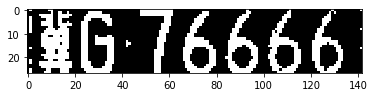

In [15]:
res_img = binary_img[rect[1]:rect[3],rect[0]:rect[2]]
plt.imshow(res_img,cmap="gray")
cv2.imwrite("img_cp.jpg",res_img)

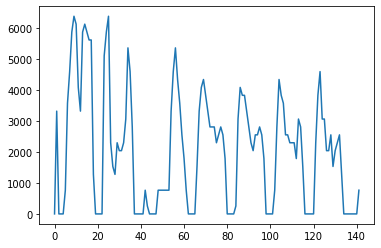

In [12]:
hist = np.sum(res_img,axis=0)
plt.plot(hist,)

In [13]:
f1 = res_img[0:27,4:20]
f2 = res_img[0:27,20:40]
f3 = res_img[0:27,45:62]
f4 = res_img[0:27,63:80]
f5 = res_img[0:27,80:100]
f6 = res_img[0:27,100:120]
f7 = res_img[0:27,120:140]


In [18]:
import os
path = "data/"
dirs = os.listdir(path)
labels = dirs
lens = 0
match = {'A':'10','B':'11','C':'12','D':'13','E':'14','F':'15','G':'16','H':'17','I':'18','J':'19','K':'20','L':'21','M':'22','N':'23',
        'O':'24','P':'25','Q':'26','R':'27','S':'28','T':'29','U':'30','V':'31','W':'32','X':'33','Y':'34','Z':'35',
        'yun':'36','cuan':'37','hei':'38','zhe':'39','ning':'40','jin':'41','gan':'42','hu':'43','liao':'44','jl':'45','qing':'46','zang':'47',
        'e1':'48','meng':'49','gan1':'50','qiong':'51','shan':'52','min':'53','su':'54','xin':'55','wan':'56','jing':'57','xiang':'58','gui':'59',
        'yu1':'60','yu':'61','ji':'62','yue':'63','gui1':'64','sx':'65','lu':'66',
        '0':'0','1':'1','2':'2','3':'3','4':'4','5':'5','6':'6','7':'7','8':'8','9':'9'}
for dir in dirs:
    class_path = path + dir + "/"
    img_paths = os.listdir(class_path)
    lens += len(img_paths)
    for img_path in img_paths:
        img_path = class_path + img_path
        img = cv2.imdecode(np.fromfile(img_path,dtype=np.uint8),0)
        # img = cv2.imread(img_path,0)
        img = cv2.resize(img,(20*20,1))

        save = pd.DataFrame(img)

        label = match[dir]
        save.insert(0,"label",label)
        save.to_csv("data.csv",index=False,header=False,mode="a+")

        print(dir,label,img_path)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'data/'

In [21]:
#SVM训练
import pandas as pd
from sklearn import svm
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [22]:
train_num = 16000
test_num = 151
data = pd.read_csv("E:\dataset\characterData\data.csv")
data = data.sample(frac=1)
train_data = data.values[0:train_num,1:]
train_label = data.values[0:train_num,0]
# train_label = train_label.reshape(-1,1)
# # print(train_label)
# enc = preprocessing.OneHotEncoder()
# enc.fit(train_label)
# train_label = enc.transform(train_label).toarray()
# print(train_label)

test_data = data.values[train_num:train_num+test_num,1:]
test_label = data.values[train_num:train_num+test_num,0]

# test_label = enc.transform(test_label.reshape(-1,1)).toarray()

# pca = PCA(n_components=0.8,whiten=True)
# train_x = pca.fit_transform(train_data)
# test_x = pca.fit_transform(test_data)
train_x = train_data
test_x = test_data

svc = svm.SVC(kernel='rbf',C=10)
svc.fit(train_x,train_label.astype("str"))
joblib.dump(svc,"model.m")
joblib.dump(pca,"pca.m")
score = svc.score(test_x,test_label.astype("str"))
print(score)

NameError: name 'pca' is not defined

In [ ]:
f1 = cv2.resize(f1,(20,20)).reshape(1,400)
f2 = cv2.resize(f2,(20,20)).reshape(1,400)
f3 = cv2.resize(f3,(20,20)).reshape(1,400)
f4 = cv2.resize(f4,(20,20)).reshape(1,400)
f5 = cv2.resize(f5,(20,20)).reshape(1,400)
f6 = cv2.resize(f6,(20,20)).reshape(1,400)
f7 = cv2.resize(f7,(20,20)).reshape(1,400)



In [ ]:
svc = joblib.load("model.m")
pre1 = svc.predict(f1)
pre2 = svc.predict(f2)
pre3 = svc.predict(f3)
pre4 = svc.predict(f4)
pre5 = svc.predict(f5)
pre6 = svc.predict(f6)
pre7 = svc.predict(f7)
ind = [pre1,pre2,pre3,pre4,pre5,pre6,pre7]


In [ ]:
match = {'A':'10','B':'11','C':'12','D':'13','E':'14','F':'15','G':'16','H':'17','I':'18','J':'19','K':'20','L':'21','M':'22','N':'23',
            'O':'24','P':'25','Q':'26','R':'27','S':'28','T':'29','U':'30','V':'31','W':'32','X':'33','Y':'34','Z':'35',
            'yun':'36','cuan':'37','hei':'38','zhe':'39','ning':'40','jin':'41','gan':'42','hu':'43','liao':'44','jl':'45','qing':'46','zang':'47',
            'e1':'48','meng':'49','gan1':'50','qiong':'51','shan':'52','min':'53','su':'54','xin':'55','wan':'56','jing':'57','xiang':'58','gui':'59',
            'yu1':'60','yu':'61','ji':'62','yue':'63','gui1':'64','sx':'65','lu':'66',
            '0':'0','1':'1','2':'2','3':'3','4':'4','5':'5','6':'6','7':'7','8':'8','9':'9'}
dict = match

In [ ]:
list(dict.keys())[list(dict.values()).index(pre)]

In [ ]:
for i in range(0,7):
    res = list(dict.keys())[list(dict.values()).index(ind[i])]
    print(res)